In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from pandas.tseries.offsets import MonthEnd
import os

sns.set(style='whitegrid')

c:\Users\Hp\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
df = pd.read_csv("monthly_sales_cleaned.csv")
df['ds'] = pd.to_datetime(df['ds']).dt.to_period('M').dt.to_timestamp()
df['y'] = df['y'].astype(float)

split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

test_df['ds'] = test_df['ds'].dt.to_period('M').dt.to_timestamp()


In [4]:
Q1 = train_df['y'].quantile(0.25)
Q3 = train_df['y'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
train_df['y'] = train_df['y'].clip(upper=upper)

holidays = pd.DataFrame({
    'holiday': ['Diwali', 'Christmas'],
    'ds': pd.to_datetime(['2017-10-19', '2017-12-25']),
    'lower_window': 0,
    'upper_window': 2
})


In [5]:
model = Prophet()

model.fit(train_df)

23:55:50 - cmdstanpy - INFO - Chain [1] start processing
23:55:54 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
train_end = train_df['ds'].max() + MonthEnd(0)
test_end = test_df['ds'].max() + MonthEnd(0)
n_months = (test_end.to_period('M') - train_end.to_period('M')).n + 1

future = model.make_future_dataframe(periods=n_months, freq='MS')
forecast = model.predict(future)

forecast_test = forecast[['ds', 'yhat']].set_index('ds') \
    .join(test_df.set_index('ds')) \
    .dropna().reset_index()
os.makedirs("output", exist_ok=True)
forecast_test.to_csv("output/test_set_forecast_results.csv", index=False)


#### Actual vs Forecasted 


Evaluation Results (Test Set):
MAE: ₹9849.54
RMSE: ₹14527.26
MAPE: 13.86%
Estimated Accuracy: 86.14%


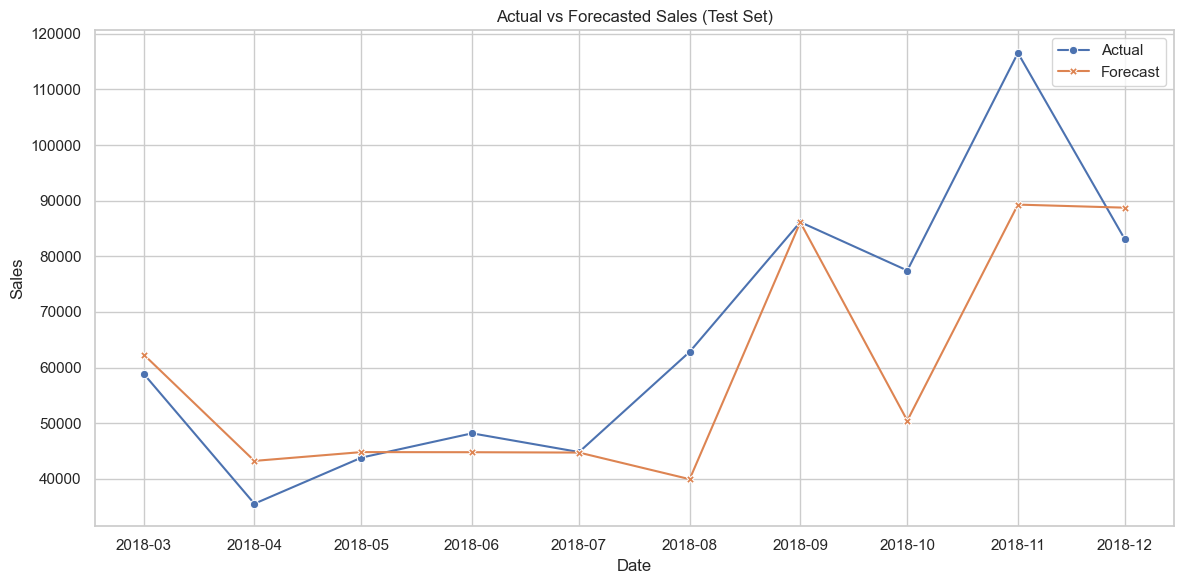

In [7]:
mae = mean_absolute_error(forecast_test['y'], forecast_test['yhat'])
rmse = sqrt(mean_squared_error(forecast_test['y'], forecast_test['yhat']))
mape = (abs(forecast_test['y'] - forecast_test['yhat']) / forecast_test['y']).mean() * 100
accuracy = 100 - mape

print("\nEvaluation Results (Test Set):")
print(f"MAE: ₹{mae:.2f}")
print(f"RMSE: ₹{rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Estimated Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(12, 6))
sns.lineplot(data=forecast_test, x='ds', y='y', label='Actual', marker='o')
sns.lineplot(data=forecast_test, x='ds', y='yhat', label='Forecast', marker='X')
plt.title("Actual vs Forecasted Sales (Test Set)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


#### Trained Data Trend Plots

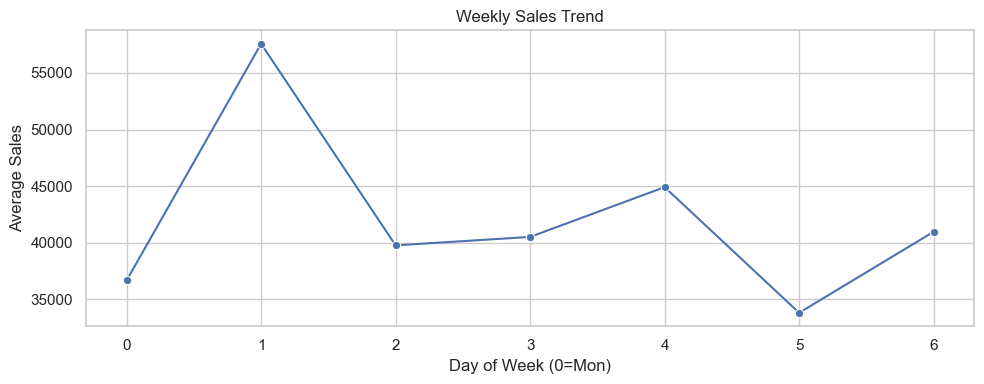

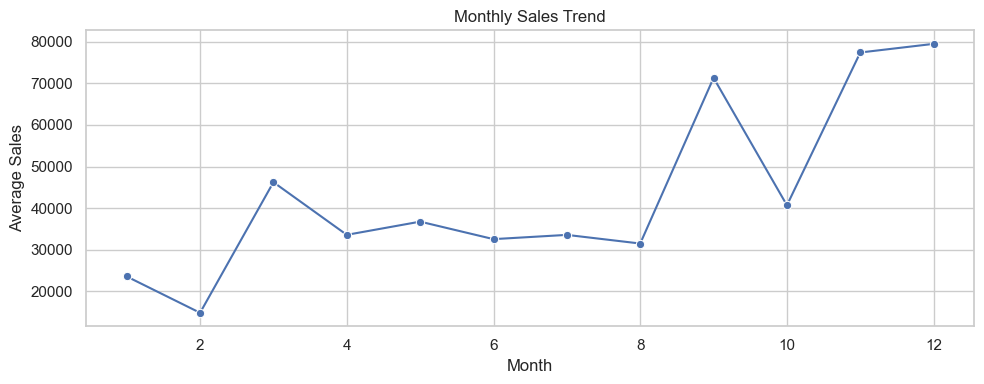

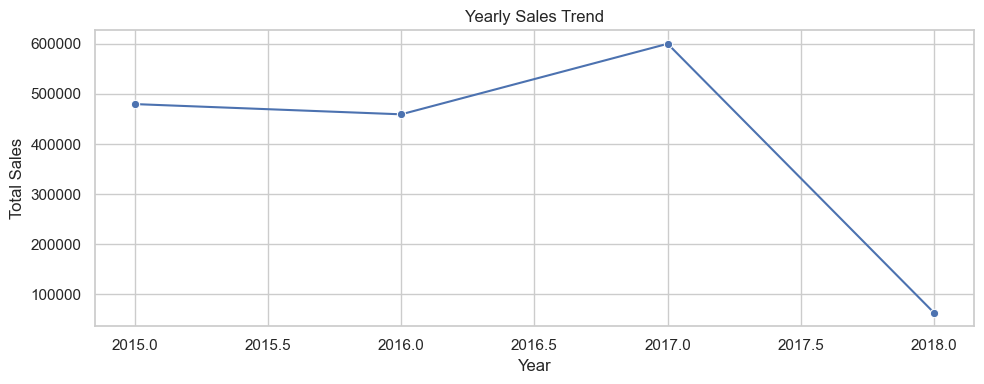

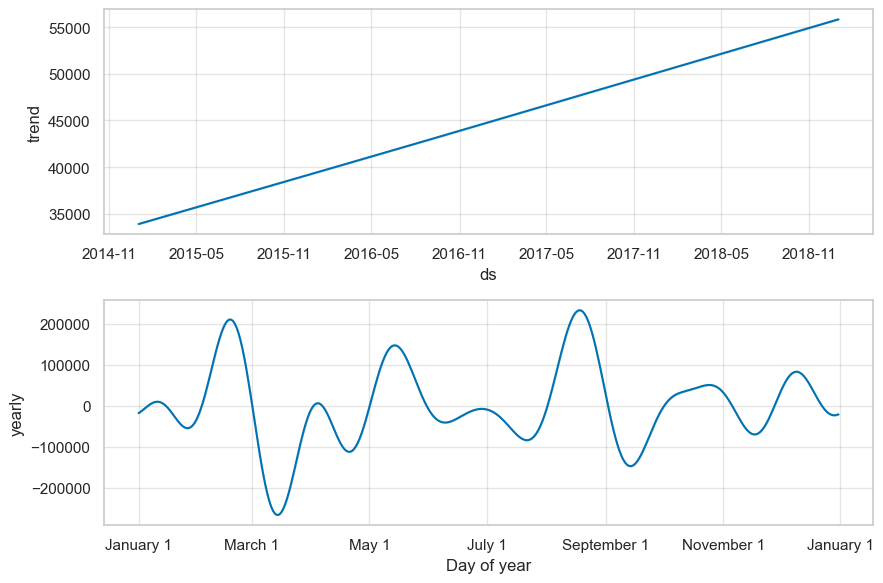

In [8]:
train_df['month'] = train_df['ds'].dt.month
train_df['weekday'] = train_df['ds'].dt.dayofweek
train_df['year'] = train_df['ds'].dt.year

# Weekly Trend
plt.figure(figsize=(10, 4))
sns.lineplot(x='weekday', y='y', data=train_df.groupby('weekday')['y'].mean().reset_index(), marker='o')
plt.title("Weekly Sales Trend")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Average Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

# Monthly Trend
plt.figure(figsize=(10, 4))
sns.lineplot(x='month', y='y', data=train_df.groupby('month')['y'].mean().reset_index(), marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

# Yearly Trend
plt.figure(figsize=(10, 4))
sns.lineplot(x='year', y='y', data=train_df.groupby('year')['y'].sum().reset_index(), marker='o')
plt.title("Yearly Sales Trend")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

# Prophet Components Trend
fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()

In [9]:
import matplotlib.dates as mdates


#### Predict into the future

23:56:00 - cmdstanpy - INFO - Chain [1] start processing
23:56:03 - cmdstanpy - INFO - Chain [1] done processing


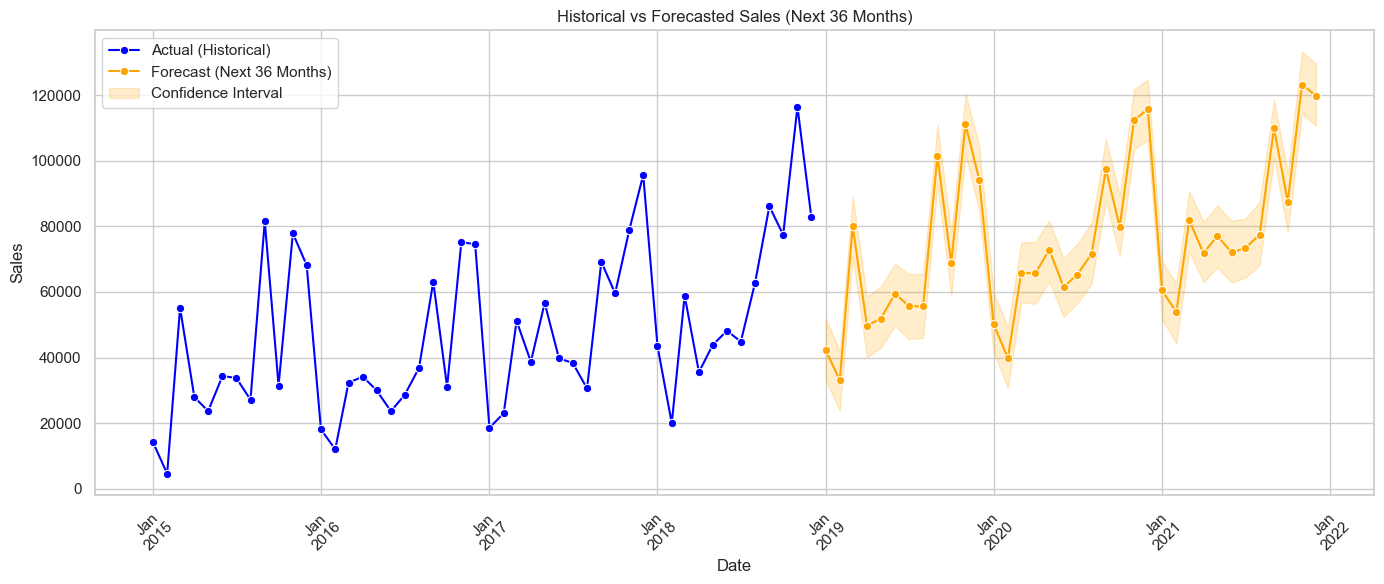

In [10]:

model_full = Prophet()
model_full.fit(df)
future_36 = model_full.make_future_dataframe(periods=36, freq='MS')
forecast_36 = model_full.predict(future_36)

plt.figure(figsize=(14, 6))
sns.lineplot(x='ds', y='y', data=df, label='Actual (Historical)', color='blue', marker='o')
forecast_only = forecast_36[forecast_36['ds'] > df['ds'].max()]
sns.lineplot(x='ds', y='yhat', data=forecast_only, label='Forecast (Next 36 Months)', color='orange', marker='o')

plt.fill_between(forecast_only['ds'], forecast_only['yhat_lower'], forecast_only['yhat_upper'], alpha=0.2, color='orange', label='Confidence Interval')

plt.title("Historical vs Forecasted Sales (Next 36 Months)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [11]:
forecast_36[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("output/forecast_next_36_months.csv", index=False)

# Save full forecast output (optional)
forecast_36.to_csv("output/full_forecast_next_36_months.csv", index=False)